# Measure fairness in healtcare-related database using the Aequitas toolkit

Simone Callegarin - 932342 - 232592 - simone.callegarin@mail.polimi.it

Link to the [github repository of the project](https://github.com/SimoneCallegarin/TIS_project).

## Imports
   All the necessary imports in order to make the notebook works.

In [26]:
!pip install aequitas
import pandas as pd
import seaborn as sns
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
# Update Pillow for graphs and images
!pip install Pillow==9.0.0
# Import the requests module for send a PUT request
import requests
# Import the base64 module for encoding a file to base64
import base64


%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing all that is needed in order to retrive the GitHub token that must be saved in a *jsoné file under the key *data_api_key*.

In [2]:
from google.colab import files
import io
import json

# Use files.upload to produce the "Choose Files" button below, then select your file.
uploaded = files.upload()

# Use io.BytesIO to decode the file, then json.load to open it.
file = io.BytesIO(uploaded['APIkey.json'])

# API token of the github repository
githubToken = json.load(file)['data_api_key']

Saving APIkey.json to APIkey.json


## Data

### Dataset
The original Diabetes Dataset has been taken from [Diabetes 130-Hospitals](https://www.openml.org/search?type=data&status=active&id=43903).

This dataset represents 10 years of clinical care at 130 U.S. hospitals and delivery networks, collected from 1999 to 2008. 
Each record represents the hospital admission record for a patient diagnosed with diabetes whose stay lasted between one to fourteen days. 
The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

The original "Diabetes 130-Hospitals" dataset was collected by Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore in 2014.

---

It was provided an already preprocessed version of the original one that can be found [here](https://www.kaggle.com/datasets/mathchi/diabetes-data-set).

All patients here are females at least 21 years old of Pima Indian heritage.

Here is the meaning of what the values of each column are referring:

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age (years)
* Outcome: Class variable (1 if diabetic, 0 otherwise)


#### Dataset download
Below data has been taken from the csv into a table.

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/SimoneCallegarin/TIS_project/master/raw_data/diabetes.csv")

df.head()

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeCategory
0,0,6.0,148,72.0,35.0,30.5,33.6,0.627,50.0,1,1
1,1,1.0,85,66.0,29.0,30.5,26.6,0.351,31.0,0,1
2,2,8.0,183,64.0,23.0,30.5,23.3,0.672,32.0,1,1
3,3,1.0,89,66.0,23.0,94.0,28.1,0.167,21.0,0,0
4,4,0.0,137,40.0,35.0,168.0,43.1,0.374,33.0,1,1


#### Preprocessing
The next step is to pre-process the Data provided in order to assess the fairness of the Dataset.

1. *Outcome* column has been renamed in *score*.

2. *AgeCategory* column has been renamed with *label_value* because it will be the attribute on which to search for discrimination.

3. The first column that was left unnamed has been renemed in *entity_id*, a reserved column name that permit us to refer to each entity.

4. Continuous values are discretized by Aequitas that will first bin the data into quartiles and then create crosstabs with the newly defined categories.

5. The final table has been reordered with all the necessary attributes.

In [80]:
df = df.rename( columns={ 'Outcome' : 'score',  
                          'AgeCategory' : 'label_value' } )
                                    
df.columns.values[0] = 'entity_id'

df, _ = preprocess_input_df(df)

# df = df[[ 'entity_id', 'score', 'label_value', 'Pregnancies', 'Glucose',	'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'	]]

df = df[[ 'entity_id', 'score', 'label_value', 'Pregnancies', 'Glucose',	'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction'	]]

df.head().style.hide(axis='index')

entity_id,score,label_value,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction
0,1.000000,1,3.00-6.00,141.00-199.00,64.00-72.00,31.00-45.00,14.00-30.50,32.00-36.30,0.55-1.00
1,0.000000,1,0.00-1.00,44.00-99.00,64.00-72.00,23.00-31.00,14.00-30.50,18.20-27.50,0.24-0.37
2,1.000000,1,6.00-13.00,141.00-199.00,38.00-64.00,10.00-23.00,14.00-30.50,18.20-27.50,0.55-1.00
3,0.000000,0,0.00-1.00,44.00-99.00,64.00-72.00,10.00-23.00,31.25-105.00,27.50-32.00,0.08-0.24
4,1.000000,1,0.00-1.00,117.00-141.00,38.00-64.00,31.00-45.00,105.00-272.00,36.30-50.00,0.24-0.37


The result of this preprocessing phase is a table with the following dimensions:

In [5]:
df.shape

(763, 10)

Note that people with an age equal or below 25 years are assigned to the AgeCategory (labeled_value) of 0 whilst the others have 1 in the column. 

In [81]:
df['score'].value_counts()

0.0    497
1.0    266
Name: score, dtype: int64

### Upload
Upload the *csv* file with the new preprocessed table into the [github repository](https://github.com/SimoneCallegarin/TIS_project/blob/main/data/diabetes.csv).

In [7]:
df.to_csv('diabetes.csv')

githubAPIURL = "https://api.github.com/repos/SimoneCallegarin/TIS_project/contents/data/diabetes.csv"

r_get = requests.get(githubAPIURL)
sha = r_get.json()['sha']

with open('diabetes.csv', "rb") as f:

    encodedData = base64.b64encode(f.read())

    headers = {
        "Authorization": f'''Bearer {githubToken}''',
        "Content-type": "application/vnd.github+json"
    }
    data = {
        "message": "Upload processed data", # commit message here.
        "content": encodedData.decode("utf-8"),
        "sha": sha
    }

    r = requests.put(githubAPIURL, headers=headers, json=data)
  
    # print(r.text) # Printing the response   

### Fairness metrics
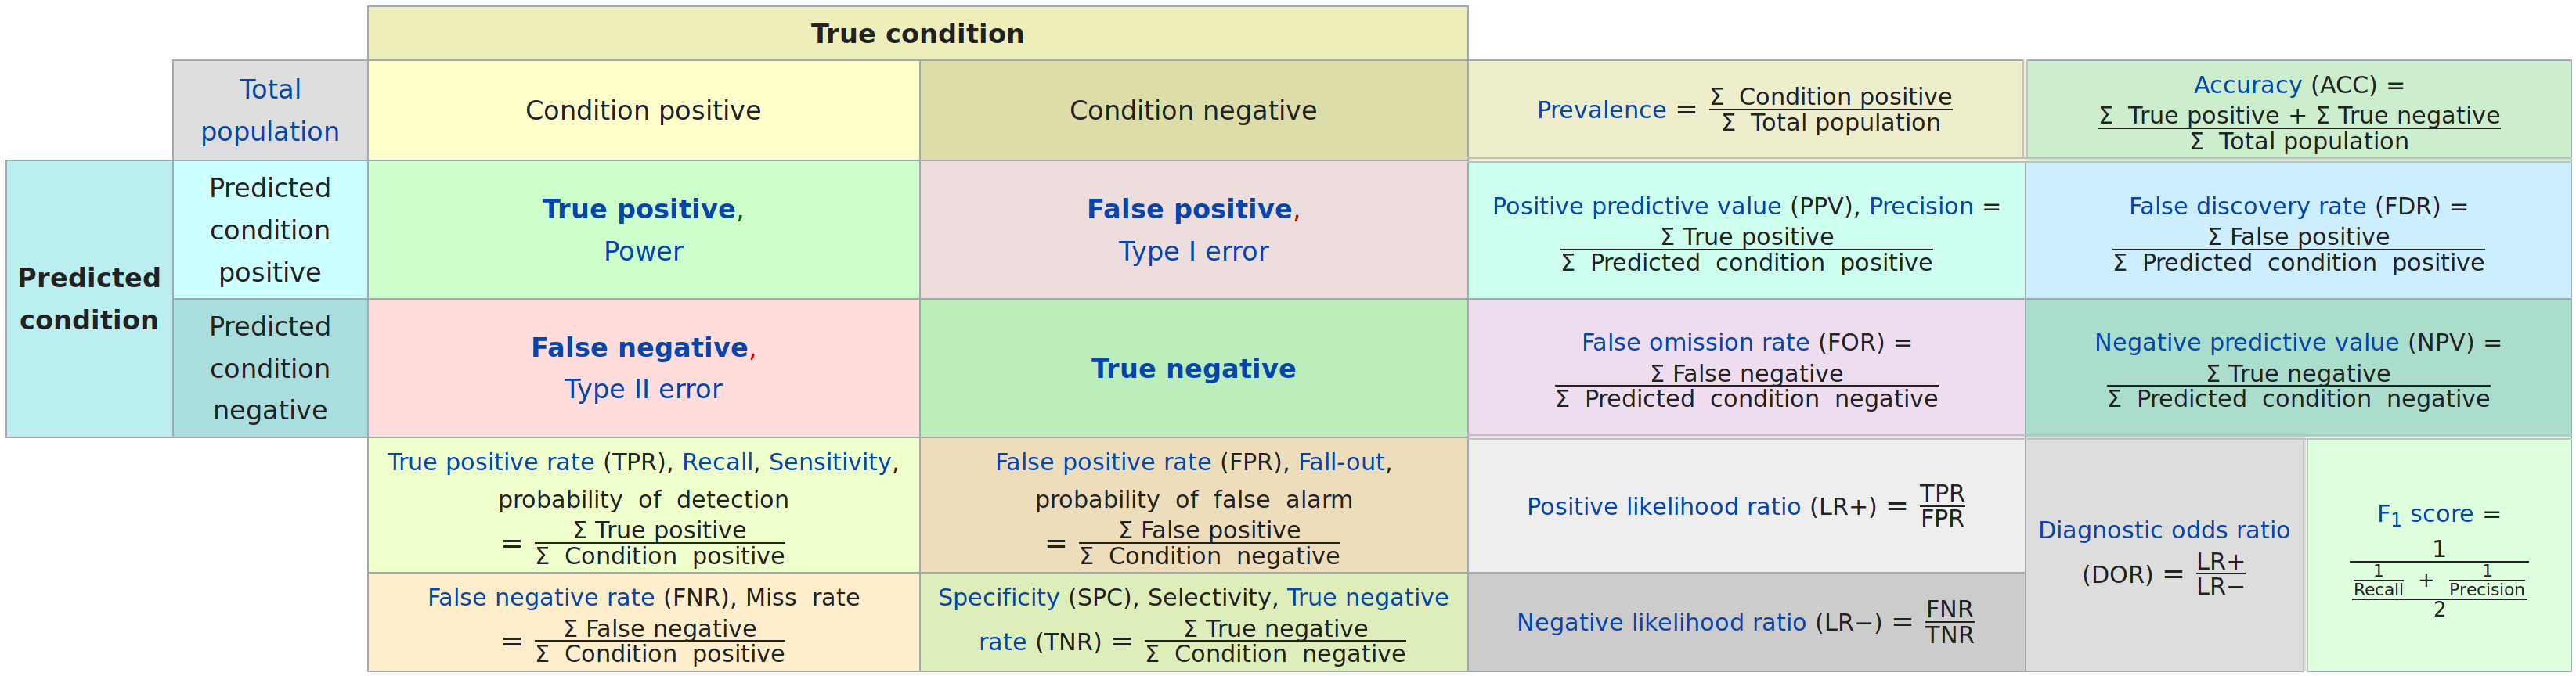


<a id='counts_description'></a>
The **`get_crosstabs()`** method tabulates a confusion matrix for each subgroup and calculates commonly used metrics such as false positive rate and false omission rate. It also provides counts by group and group prevelances.

#### Group Counts Calculated:

| Count Type | Column Name |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' | 
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

#### Absolute Metrics Calculated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate | 'tpr' |
| True Negative Rate | 'tnr' |
| False Omission Rate | 'for' |
| False Discovery Rate | 'fdr' |
| False Positive Rate | 'fpr' |
| False Negative Rate | 'fnr' |
| Negative Predictive Value | 'npv' |
| Precision | 'precision' |
| Predicted Positive Ratio$_k$ | 'ppr' |
| Predicted Positive Ratio$_g$ | 'pprev' |
| Group Prevalence | 'prev' |


In [139]:
def color_val(value):
    if type(value) != type(''):
        color = 'red' if value < 1 else 'green'
        return 'color: {}'.format(color)

In [147]:
g = Group()
xtab, _ = g.get_crosstabs(df)
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]
xtab_style = xtab.style
xtab_style.background_gradient(axis=0, subset = ['tpr','tnr','for','fdr','fpr','fnr','npv'])
xtab_style.set_properties(**{'background-color': 'white','color': 'black'}, subset = ['attribute_name'])
xtab_style.hide(axis = 'columns',subset = ['model_id','k','score_threshold'])
xtab_style

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,Pregnancies,0.00-1.00,0.444444,0.840278,0.312500,0.343284,0.159722,0.555556,0.687500,0.656716,67,176,0.251880,0.275720,23,55,121,44,99,144,243,763,0.407407
1,Pregnancies,1.00-3.00,0.400000,0.835052,0.386364,0.320000,0.164948,0.600000,0.613636,0.680000,50,132,0.187970,0.274725,16,51,81,34,85,97,182,763,0.467033
2,Pregnancies,3.00-6.00,0.348684,0.761905,0.860870,0.086207,0.238095,0.651316,0.139130,0.913793,58,115,0.218045,0.335260,5,99,16,53,152,21,173,763,0.878613
3,Pregnancies,6.00-13.00,0.552147,0.500000,0.986486,0.010989,0.500000,0.447853,0.013514,0.989011,91,74,0.342105,0.551515,1,73,1,90,163,2,165,763,0.987879
4,Glucose,117.00-141.00,0.439394,0.724138,0.637931,0.216216,0.275862,0.560606,0.362069,0.783784,74,116,0.278195,0.389474,16,74,42,58,132,58,190,763,0.694737
5,Glucose,141.00-199.00,0.720779,0.424242,0.754386,0.146154,0.575758,0.279221,0.245614,0.853846,130,57,0.488722,0.695187,19,43,14,111,154,33,187,763,0.823529
6,Glucose,44.00-99.00,0.130435,0.980000,0.449438,0.142857,0.020000,0.869565,0.550562,0.857143,14,178,0.052632,0.072917,2,80,98,12,92,100,192,763,0.479167
7,Glucose,99.00-117.00,0.330579,0.890411,0.554795,0.166667,0.109589,0.669421,0.445205,0.833333,48,146,0.180451,0.247423,8,81,65,40,121,73,194,763,0.623711
8,BloodPressure,38.00-64.00,0.394737,0.876033,0.302632,0.333333,0.123967,0.605263,0.697368,0.666667,45,152,0.169173,0.228426,15,46,106,30,76,121,197,763,0.385787
9,BloodPressure,64.00-72.00,0.464052,0.835616,0.573427,0.144578,0.164384,0.535948,0.426573,0.855422,83,143,0.312030,0.367257,12,82,61,71,153,73,226,763,0.676991


In [9]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,Pregnancies,0.00-1.00,0.44,0.84,0.31,0.34,0.16,0.56,0.69,0.66,0.25,0.28,0.41
1,Pregnancies,1.00-3.00,0.40,0.84,0.39,0.32,0.16,0.60,0.61,0.68,0.19,0.27,0.47
2,Pregnancies,3.00-6.00,0.35,0.76,0.86,0.09,0.24,0.65,0.14,0.91,0.22,0.34,0.88
3,Pregnancies,6.00-13.00,0.55,0.50,0.99,0.01,0.50,0.45,0.01,0.99,0.34,0.55,0.99
4,Glucose,117.00-141.00,0.44,0.72,0.64,0.22,0.28,0.56,0.36,0.78,0.28,0.39,0.69
5,Glucose,141.00-199.00,0.72,0.42,0.75,0.15,0.58,0.28,0.25,0.85,0.49,0.70,0.82
6,Glucose,44.00-99.00,0.13,0.98,0.45,0.14,0.02,0.87,0.55,0.86,0.05,0.07,0.48
7,Glucose,99.00-117.00,0.33,0.89,0.55,0.17,0.11,0.67,0.45,0.83,0.18,0.25,0.62
8,BloodPressure,38.00-64.00,0.39,0.88,0.30,0.33,0.12,0.61,0.70,0.67,0.17,0.23,0.39
9,BloodPressure,64.00-72.00,0.46,0.84,0.57,0.14,0.16,0.54,0.43,0.86,0.31,0.37,0.68


In [10]:
b = Bias()

In [158]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, ref_groups_dict={'Pregnancies':'0.00-1.00', 'Glucose':'99.00-117.00', 'BloodPressure':'64.00-72.00', 'SkinThickness':'10.00-23.00', 'Insulin':'14.00-30.50', 'BMI':'27.50-32.00', 'DiabetesPedigreeFunction':'0.24-0.37'}, alpha=0.05, mask_significance=True)
bdf_style = bdf.style
bdf_style.background_gradient(axis=0, subset = ['tpr','tnr','for','fdr','fpr','fnr','npv'])
bdf_style.set_properties(**{'background-color': 'white','color': 'black'}, subset = ['attribute_name'])
bdf_style.hide(axis = 'columns',subset = ['model_id','k','score_threshold'])
bdf_style

get_disparity_predefined_group()


,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,Pregnancies,0.00-1.00,0.444444,0.840278,0.312500,0.343284,0.159722,0.555556,0.687500,0.656716,67,176,0.251880,0.275720,23,55,121,44,99,144,243,763,0.407407,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00
1,Pregnancies,1.00-3.00,0.400000,0.835052,0.386364,0.320000,0.164948,0.600000,0.613636,0.680000,50,132,0.187970,0.274725,16,51,81,34,85,97,182,763,0.467033,0.746269,0.996392,1.035455,0.932174,1.236364,1.032721,1.080000,0.900000,0.993780,0.892562,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00
2,Pregnancies,3.00-6.00,0.348684,0.761905,0.860870,0.086207,0.238095,0.651316,0.139130,0.913793,58,115,0.218045,0.335260,5,99,16,53,152,21,173,763,0.878613,0.865672,1.215943,1.391458,0.251124,2.754783,1.490683,1.172368,0.784539,0.906730,0.202372,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00
3,Pregnancies,6.00-13.00,0.552147,0.500000,0.986486,0.010989,0.500000,0.447853,0.013514,0.989011,91,74,0.342105,0.551515,1,73,1,90,163,2,165,763,0.987879,1.358209,2.000271,1.505994,0.032011,3.156757,3.130435,0.806135,1.242331,0.595041,0.019656,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00,0.00-1.00
4,Glucose,117.00-141.00,0.439394,0.724138,0.637931,0.216216,0.275862,0.560606,0.362069,0.783784,74,116,0.278195,0.389474,16,74,42,58,132,58,190,763,0.694737,1.541667,1.574123,0.940541,1.297297,1.149851,2.517241,0.837449,1.329167,0.813263,0.813263,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00
5,Glucose,141.00-199.00,0.720779,0.424242,0.754386,0.146154,0.575758,0.279221,0.245614,0.853846,130,57,0.488722,0.695187,19,43,14,111,154,33,187,763,0.823529,2.708333,2.809715,1.024615,0.876923,1.359757,5.253788,0.417108,2.180357,0.476457,0.551687,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00
6,Glucose,44.00-99.00,0.130435,0.980000,0.449438,0.142857,0.020000,0.869565,0.550562,0.857143,14,178,0.052632,0.072917,2,80,98,12,92,100,192,763,0.479167,0.291667,0.294705,1.028571,0.857143,0.810098,0.182500,1.298980,0.394565,1.100615,1.236646,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00
7,Glucose,99.00-117.00,0.330579,0.890411,0.554795,0.166667,0.109589,0.669421,0.445205,0.833333,48,146,0.180451,0.247423,8,81,65,40,121,73,194,763,0.623711,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00,99.00-117.00
8,BloodPressure,38.00-64.00,0.394737,0.876033,0.302632,0.333333,0.123967,0.605263,0.697368,0.666667,45,152,0.169173,0.228426,15,46,106,30,76,121,197,763,0.385787,0.542169,0.621980,0.779343,2.305556,0.527760,0.754132,1.129332,0.850630,1.048367,1.634814,64.00-72.00,64.00-72.00,64.00-72.00,64.00-72.00,64.00-72.00,64.00-72.00,64.00-72.00,64.00-72.00,64.00-72.00,64.00-72.00
9,BloodPressure,64.00-72.00,0.464052,0.835616,0.573427,0.144578,0.164384,0.535948,0.426573,0.855422,83,143,0.312030,0.367257,12,82,61,71,153,73,226,763,0.676991,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000

In [13]:
calculated_disparities = b.list_disparities(bdf)
disparity_significance = b.list_significance(bdf)

In [160]:
bdf[['attribute_name', 'attribute_value'] +  calculated_disparities]
# bdf[['attribute_name', 'attribute_value','fnr','fnr_disparity']]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,Pregnancies,0.00-1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Pregnancies,1.00-3.00,0.746269,0.996392,1.035455,0.932174,1.236364,1.032721,1.080000,0.900000,0.993780,0.892562
2,Pregnancies,3.00-6.00,0.865672,1.215943,1.391458,0.251124,2.754783,1.490683,1.172368,0.784539,0.906730,0.202372
3,Pregnancies,6.00-13.00,1.358209,2.000271,1.505994,0.032011,3.156757,3.130435,0.806135,1.242331,0.595041,0.019656
4,Glucose,117.00-141.00,1.541667,1.574123,0.940541,1.297297,1.149851,2.517241,0.837449,1.329167,0.813263,0.813263
5,Glucose,141.00-199.00,2.708333,2.809715,1.024615,0.876923,1.359757,5.253788,0.417108,2.180357,0.476457,0.551687
6,Glucose,44.00-99.00,0.291667,0.294705,1.028571,0.857143,0.810098,0.182500,1.298980,0.394565,1.100615,1.236646
7,Glucose,99.00-117.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,BloodPressure,38.00-64.00,0.542169,0.621980,0.779343,2.305556,0.527760,0.754132,1.129332,0.850630,1.048367,1.634814
9,BloodPressure,64.00-72.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [226]:
def highlight(value):
  if type(value) != type(''):
    if value.attribute_name == 'Pregnancies':
        return ['background-color: 	#CCCCCC'] * len(value)
    if value.attribute_name == 'Glucose':
        return ['background-color: 	#BFBFBF'] * len(value)

In [227]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)
parity_detrminations = f.list_parities(fdf)
#fdf[['attribute_name', 'attribute_value'] + absolute_metrics + calculated_disparities + parity_detrminations].style
fdf_style = fdf[['attribute_name', 'attribute_value'] + parity_detrminations].style
#fdf[['attribute_name', 'attribute_value', 'FNR Parity']].style

#fdf_style.background_gradient(axis=0, subset = ['tpr','tnr','for','fdr','fpr','fnr','npv'])
fdf_style.set_properties(**{'background-color': 'white','color': 'black'}, subset = ['attribute_name'])
fdf_style.applymap(color_val)
fdf_style.apply(highlight, axis = 1)
fdf_style

,attribute_name,attribute_value,NPV Parity,FPR Parity,Precision Parity,TNR Parity,Unsupervised Fairness,Equalized Odds,TypeII Parity,Supervised Fairness,FNR Parity,FDR Parity,Statistical Parity,TPR Parity,FOR Parity,TypeI Parity,Impact Parity
0,Pregnancies,0.00-1.00,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,Pregnancies,1.00-3.00,True,True,True,True,False,True,True,True,True,True,False,True,True,True,True
2,Pregnancies,3.00-6.00,False,False,False,True,True,False,False,False,True,False,True,False,False,False,True
3,Pregnancies,6.00-13.00,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,Glucose,117.00-141.00,True,False,True,True,False,False,True,False,True,False,False,False,True,False,False
5,Glucose,141.00-199.00,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
6,Glucose,44.00-99.00,True,False,True,True,False,False,False,False,False,True,False,False,True,False,False
7,Glucose,99.00-117.00,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
8,BloodPressure,38.00-64.00,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False
9,BloodPressure,64.00-72.00,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [32]:
metrics = ['fpr','fnr']
disparity_tolerance = 1.3
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

alt.VConcatChart(...)

In [28]:
ap.disparity(bdf, metrics, 'Glucose', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [29]:
ap.disparity(bdf, metrics, 'Insulin', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

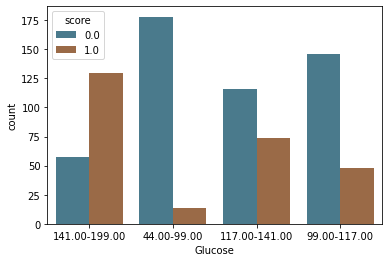

In [31]:
aq_palette = sns.diverging_palette(225, 35, n=2)
by_sex = sns.countplot(x="Glucose", hue="score", data=df, palette=aq_palette)

# Bibliography

Dataset:
* https://www.kaggle.com/datasets/mathchi/diabetes-data-set
* https://www.openml.org/search?type=data&status=active&id=43903&sort=runs

Fairness metrics:
* https://arxiv.org/pdf/1811.05577v2.pdf
* http://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/
* https://dssg.github.io/fairness_tutorial/notebooks/
* https://www.labelia.org/en/blog/fairness-in-machine-learning
* https://cscherrer.github.io/post/confusion-confusion/
